In [210]:
#Importing Libraries
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import time
import nltk
import regex as re
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from collections import Counter
import matplotlib as plt
from sklearn.naive_bayes import BernoulliNB

In [2]:
#Setting my URL name to run
run = 'https://www.reddit.com/r/running.json'

In [3]:
# Setting a header to get rid of my 429 error code
headers = {'User-agent': 'Kevin'}

In [4]:
# Setting my request variable and using the header param to identify me as a unique agent
res = requests.get(run, headers=headers)

In [5]:
# Rechecking status code to make sure it's ok now
res.status_code

200

In [6]:
# Checking res.content to see if it's pulling the information correctly
# res.content

#COMMENTING OUT TO SAVE SPACE

In [7]:
#Setting a json variable to just pull the json dictionary from Reddit's API
the_json = res.json()

In [8]:
#Checking the keys in my dictionary
the_json.keys()

dict_keys(['kind', 'data'])

In [9]:
#Even though there are only two, I'm sorting the keys to get in the habit of doing so
sorted(the_json.keys())

['data', 'kind']

In [10]:
# Checking my kind key to see what values are with it
the_json['kind']

'Listing'

In [11]:
# Since kind didnt have much, assuming most info is in data
# the_json['data']

#COMMENTING OUT TO SAVE SPACE

In [12]:
#Since this is a list of dictionaries, sorting the keys withing the values of data
sorted(the_json['data'].keys())

['after', 'before', 'children', 'dist', 'modhash']

In [13]:
#Since children represents the actual Reddit posts, checking how many I have
len(the_json['data']['children'])

27

In [14]:
#Creating a dataframe quickly to see if it's organizing the data correctly
# pd.DataFrame(the_json['data']['children'])

#COMMENTING OUT TO SAVE SPACE

In [15]:
#Looking at first post and first key  in that post
# the_json['data']['children'][0]['data']

#COMMENTING OUT TO SAVE SPACE

In [16]:
#Checking the name for the last post which needs to be anchor for accessing API
the_json['data']['after']

't3_cbezui'

In [17]:
# checking the name for all 27 posts
# [post['data']['name'] for post in the_json['data']['children']]

#COMMENTING OUT TO SAVE SPACE

In [18]:
param = {'after': 't3_c8bu5g'}

In [19]:
requests.get(run, params=param, headers=headers)

<Response [200]>

In [21]:
runposts = []
after = None
for i in range(38): 
#     print(i) #COMMENTING OUT TO SAVE SPACE
    if after == None:
        params = {}
    else:
        params = {'after': after}
    run = 'https://www.reddit.com/r/running/.json'
    res = requests.get(run, params=params, headers=headers)
    if res.status_code == 200:
        the_json = res.json()
        runposts.extend(the_json['data']['children'])
        after = the_json['data']['after']
    else:
        print(res.status_code)
        break
    time.sleep(1) 

In [22]:
# Checking the length of posts to see how many we got
len(runposts)

929

In [23]:
#checking the unique posts to make sure we're not getting overlap
len(set([p['data']['name'] for p in runposts]))

702

In [24]:
#Checking the first element in posts to see if data was pulled correctly
# runposts[0]

#COMMENTING OUT TO SAVE SPACE

In [25]:
cfposts = []
after = None
for i in range(38): 
#     print(i) #COMMENTING OUT TO SAVE SPACE
    if after == None:
        params = {}
    else:
        params = {'after': after}
    cf = 'https://www.reddit.com/r/crossfit.json'
    res = requests.get(cf, params=params, headers=headers)
    if res.status_code == 200:
        the_json = res.json()
        cfposts.extend(the_json['data']['children'])
        after = the_json['data']['after']
    else:
        print(res.status_code)
        break
    time.sleep(1)

In [26]:
# Checking the length of posts to see how many we got
len(cfposts)

950

In [27]:
#checking the unique posts to make sure we're not getting overlap
len(set([p['data']['name'] for p in cfposts]))

950

In [28]:
cf_posts = []
for i in cfposts:
    cf_posts.append(i['data']['selftext'])

In [29]:
cf_df = pd.DataFrame(cf_posts)

In [30]:
cf_df['from_cf'] = 1

In [31]:
cf_df.head()

,0,from_cf
0,,1
1,"Hi all, I started building me a home gym and I...",1
2,I live pretty close to Central but traveling a...,1
3,,1
4,"Hey all, I have just been curious lately about...",1


In [32]:
cf_df.rename(columns={0: 'Post'}, inplace=True)

In [33]:
cf_df = cf_df[cf_df['Post'] != '']

In [34]:
cf_df = cf_df.replace('\n',' ', regex=True) 

In [207]:
cf_df.head(10)

,Post,from_cf
1,"Hi all, I started building me a home gym and I...",1
2,I live pretty close to Central but traveling a...,1
4,"Hey all, I have just been curious lately about...",1
5,Can someone teach how to record biometrics dur...,1
6,"So, maybe I should be turning to my therapist ...",1
7,I have gone to 2 CrossFit classes and each one...,1
8,While getting back from a knee injury by resti...,1
10,Hello! I was wondering if anyone could recomm...,1
12,As the header says I’m wondering how bad this ...,1
14,The Start/Stop has water damage to it and I ju...,1


In [36]:
cf_df.shape

(732, 2)

In [37]:
run_posts = []
for i in runposts:
    run_posts.append(i['data']['selftext'])

In [38]:
run_df = pd.DataFrame(run_posts)

In [39]:
run_df.rename(columns={0: 'Post'}, inplace=True)

In [40]:
run_df = run_df[run_df['Post'] != '']

In [41]:
run_df = run_df.replace('\n',' ', regex=True) 

In [42]:
run_df['from_cf'] = 0

In [43]:
run_df.head()

,Post,from_cf
0,***NOTE: This post was graciously stolen (w/ ...,0
1,"With over 600,000 users, there are a lot of p...",0
3,"Hello everyone, this is my first post in this ...",0
4,"Good morning, Runnit! Another weekend of races...",0
5,How are you feeling today? Anything nagging yo...,0


In [44]:
run_df.head()

,Post,from_cf
0,***NOTE: This post was graciously stolen (w/ ...,0
1,"With over 600,000 users, there are a lot of p...",0
3,"Hello everyone, this is my first post in this ...",0
4,"Good morning, Runnit! Another weekend of races...",0
5,How are you feeling today? Anything nagging yo...,0


In [45]:
run_df.shape

(869, 2)

In [46]:
df = pd.concat([run_df, cf_df], axis=0)

In [208]:
df.head(10)

,Post,from_cf
0,***NOTE: This post was graciously stolen (w/ ...,0
1,"With over 600,000 users, there are a lot of p...",0
3,"Hello everyone, this is my first post in this ...",0
4,"Good morning, Runnit! Another weekend of races...",0
5,How are you feeling today? Anything nagging yo...,0
6,I am making a switch over to more meatless day...,0
7,"F26, although I was fairly athletic in high sc...",0
8,I have a really bad case of scoliosis. On top...,0
9,My husband wants to borrow my 235 to check his...,0
10,What would be a relatively cheap running/fitne...,0


In [48]:
df.shape

(1601, 2)

In [49]:
df.describe()

,from_cf
count,1601.000000
mean,0.457214
std,0.498322
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [50]:
df.dtypes

Post       object
from_cf     int64
dtype: object

In [51]:
# Defining my X and my y

X = df['Post']
y = df['from_cf']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42)

In [53]:
def post_to_words(raw_post):
    # Function to convert a raw post to a string of words
    # The input is a single string (post), and 
    # the output is a single string (a preprocessed post)
    
    # 1. Remove HTML.
    post_text = BeautifulSoup(raw_post).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", post_text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. Convert the stop words to a set.
    stops = set(stopwords.words('english'))
    
    # 5. Remove stop words.
    meaningful_words = [w for w in words if not w in stops]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [57]:
# Get the number of posts based on the dataframe size.
total_posts = X_train.shape[0]
print(f'There are {total_posts} posts.')

# Initialize an empty list to hold the clean posts.
clean_train_posts = []
clean_test_posts = []

There are 1200 posts.


In [58]:
clean_train_posts

[]

In [59]:
print("Cleaning and parsing the training set posts...")

j = 0
for train_post in X_train:
    # Convert post to words, then append to clean_train_post.
    clean_train_posts.append(post_to_words(train_post))
    
    j += 1

# Doing the same for the testing set.

print("Cleaning and parsing the testing set posts...")

for test_post in X_test:
    # Convert post to words, then append to clean_test_posts.
    clean_test_posts.append(post_to_words(test_post))
        
    j += 1

Cleaning and parsing the training set posts...
Cleaning and parsing the testing set posts...


/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:335: UserWarning: "https://www.instagram.com/p/ByBe5uIHS8A/?igshid=134on10te20yc" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [60]:
clean_test_posts

['hey everybody exchange student denmark going abroad sydney next months seems like boxes pretty small quite expensive membership fee anybody experience boxes sydney',
 'race information boston k june far km boston finish time x b goals goal description completed sub b sub c finish without walking yes x b x b splits kilometer time x b training used pretty inconsistent runner got days ran led series injuries running half marathon walk whole second last km decided time going different least going train x b thought fit enough hal higdon advanced k plan pr around wanted beat ambitious weeks train since decided wanted run today race day last weeks first two weeks great felt super confident however last week miserable finish workouts wanted x b pre race go boston commons around picked shirt left along belongings gear check light dynamic exercises drank water could feel going get hot finally rounded us according times pumped x b race started great soon felt goals absolutely impossible way hot

In [61]:
clean_train_posts

['hey fellow competitive km km racers question community part question personal opinion tempo workouts done used xcseason done race pace comfortable e say tempo days team comfortably able cruise talk decently together unit b tempos used tool staying fit season would intervals considerably effective keep tempos offseason would love hear different opinions matter since every person speak different outlook matter entirely thanks advance curious college runner',
 'meaning run ks ks think ever done life given reason get tomorrow run miles nonstop mind possible body physically handle since never trained anywhere near long',
 'freshman year highschool first time running seriously cross country ran varsity guys massively successful got injured halfway got stress fracture backed mri foot blame sudden increase training forefoot aggressive shoes ran indoor track wearing boot got mile unfortunately track field another spring sport sophomore year highschool last year nice cushioned shoe began aggre

In [68]:
# Instantiate the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = 'english',
                             max_features=5_000)

In [69]:
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.

train_data_features = vectorizer.fit_transform(clean_train_posts)

test_data_features = vectorizer.transform(clean_test_posts)

# Numpy arrays are easy to work with, so convert the result to an 
# array.
train_data_features = train_data_features.toarray()

In [70]:
print(train_data_features.shape)

(1200, 5000)


In [71]:
print(test_data_features.shape)

(401, 5000)


In [72]:
y_train.shape

(1200,)

In [73]:
train_data_features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [74]:
train_data_features[0:6]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [75]:
vocab = vectorizer.get_feature_names()
print(vocab)

['aab', 'aaron', 'ab', 'abdominal', 'abilities', 'ability', 'able', 'abort', 'abroad', 'absolute', 'absolutely', 'ac', 'academy', 'accept', 'accepted', 'access', 'accessory', 'accident', 'accidentally', 'acclimated', 'accomplish', 'accomplished', 'accomplishment', 'accomplishments', 'according', 'account', 'accounts', 'accumulate', 'accuracy', 'accurate', 'accustomed', 'ache', 'acheive', 'achievable', 'achieve', 'achieved', 'achievement', 'achievements', 'achieving', 'achill', 'achilles', 'aching', 'acid', 'action', 'active', 'activities', 'activity', 'actual', 'actually', 'adapt', 'add', 'added', 'adding', 'addition', 'additional', 'adductor', 'adequate', 'adhd', 'adidas', 'adjust', 'adjusted', 'adjustment', 'adjustments', 'admit', 'adrenaline', 'ads', 'advance', 'advanced', 'advantage', 'adventure', 'advice', 'aerobic', 'aesthetics', 'af', 'affair', 'affairs', 'affect', 'affected', 'affiliate', 'affiliated', 'affiliates', 'afford', 'affordable', 'afraid', 'aftermath', 'afternoon', 'a

In [91]:
vocab[0:5]

['aab', 'aaron', 'ab', 'abdominal', 'abilities']

In [76]:
#Checking baseline to see if our model is out performing the null model
df['from_cf'].value_counts(normalize=True)

0    0.542786
1    0.457214
Name: from_cf, dtype: float64

In [77]:
lr = LogisticRegression()

In [78]:
lr.fit(train_data_features, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [79]:
print(f'Logistic Regression Intercept: {lr.intercept_}')
print(f'Logistic Regression Coefficient: {lr.coef_}')

Logistic Regression Intercept: [1.23596293]
Logistic Regression Coefficient: [[ 3.05774481e-04  4.65769574e-09 -9.65000140e-03 ...  3.21906661e-06
   7.73314905e-07  2.19312248e-04]]


In [81]:
print(f'Logistic Regression Coefficient: {np.exp(lr.coef_)}')

Logistic Regression Coefficient: [[1.00030582 1.         0.99039641 ... 1.00000322 1.00000077 1.00021934]]


In [82]:
#Generate predicted values.
print(f'Logreg predicted values: {lr.predict(train_data_features[0:5])}')

Logreg predicted values: [0 0 0 1 0]


In [83]:
#Generate predicted probabilities.
print(f'Logreg predicted probabilities: {lr.predict_proba(train_data_features[0:5])}')

Logreg predicted probabilities: [[9.56328429e-01 4.36715705e-02]
 [9.69148557e-01 3.08514426e-02]
 [9.99999037e-01 9.62682801e-07]
 [3.95758556e-03 9.96042414e-01]
 [9.99299613e-01 7.00386666e-04]]


In [84]:
# Evaluate model on training data.
print(f' Train Score is: {np.round(lr.score(train_data_features, y_train), decimals=4)*100}')

 Train Score is: 99.75


In [85]:
# Evaluate model on testing data.

print(f' Test Score is: {np.round(lr.score(test_data_features, y_test), decimals=4)*100}')

 Test Score is: 96.00999999999999


In [128]:
train_data_features_cv = pd.DataFrame(train_data_features,
                                columns = vectorizer.get_feature_names())

In [130]:
X_df = pd.DataFrame(train_data_features.sum(), index = vectorizer.get_feature_names(), columns =['count'])

In [131]:
X_df['coef'] = lr.coef_.T

In [153]:
X_df.isnull().sum()

count    0
coef     0
dtype: int64

In [166]:
top_10 = X_df.sort_values(by=['coef'], ascending=False).head(10)

In [174]:
top_10

,count,coef
crossfit,93717,1.892996
box,93717,1.076023
gym,93717,0.969589
murph,93717,0.857553
cf,93717,0.846285
workout,93717,0.813875
games,93717,0.793888
wods,93717,0.727410
wod,93717,0.722046
bar,93717,0.677545


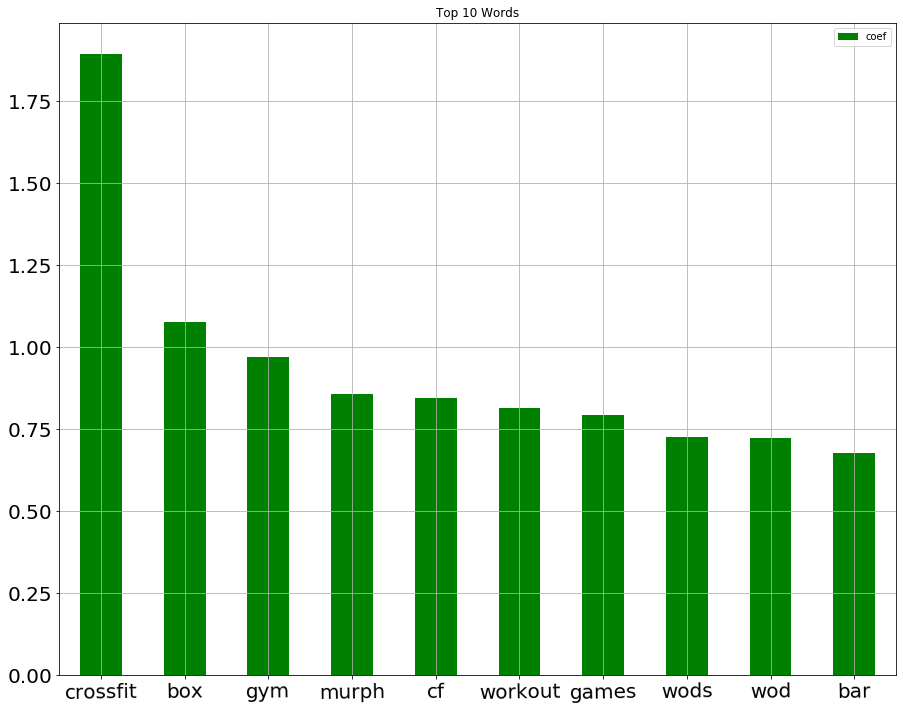

In [206]:
top_10['coef'].plot.bar(
                        rot = 1, 
                        figsize=(15,12),
                        color = 'green',
                        grid=True,
                        legend=True,
                        fontsize=20,
                        title="Top 10 Words");

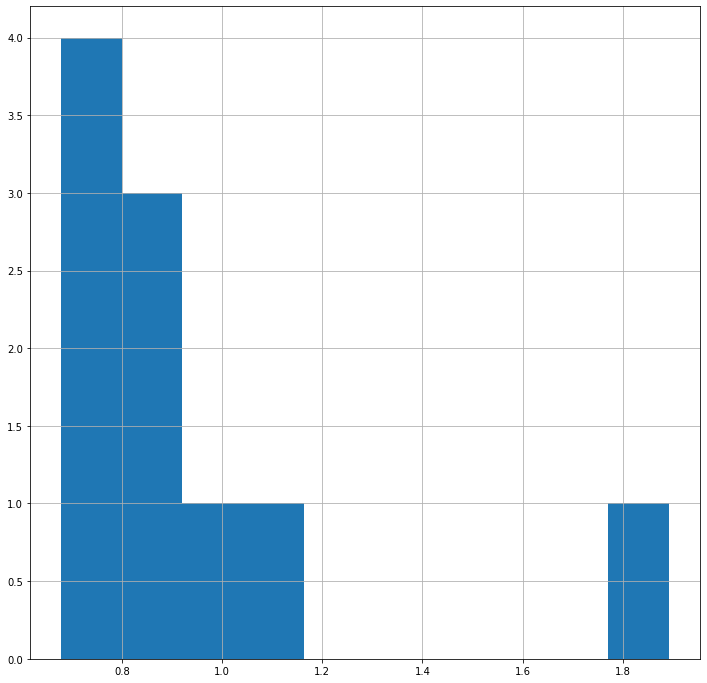

In [86]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

In [87]:
# Evaluate how your model will perform on unseen data
print(f' Cross_val_score is: {cross_val_score(pipe, X_train, y_train, cv=3).mean()}') 

# Fit your model
pipe.fit(X_train, y_train)

# Training score
print(f' Training Score is: {pipe.score(X_train, y_train)}')

# Test score
print(f' Test Score is: {pipe.score(X_test, y_test)}')

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 Cross_val_score is: 0.9225
 Training Score is: 0.9983333333333333
 Test Score is: 0.9551122194513716


In [213]:
pipe_params = {
    'cvec__max_features': [2500, 3000, 3500, 10_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9241666666666667


{'cvec__max_df': 0.9,
 'cvec__max_features': 10000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [214]:
gs.score(X_train, y_train)

0.9983333333333333

In [215]:
gs.score(X_test, y_test)

0.9526184538653366

In [142]:
Counter(vocab).keys() # equals to list(set(words))

dict_keys(['aab', 'aaron', 'ab', 'abdominal', 'abilities', 'ability', 'able', 'abort', 'abroad', 'absolute', 'absolutely', 'ac', 'academy', 'accept', 'accepted', 'access', 'accessory', 'accident', 'accidentally', 'acclimated', 'accomplish', 'accomplished', 'accomplishment', 'accomplishments', 'according', 'account', 'accounts', 'accumulate', 'accuracy', 'accurate', 'accustomed', 'ache', 'acheive', 'achievable', 'achieve', 'achieved', 'achievement', 'achievements', 'achieving', 'achill', 'achilles', 'aching', 'acid', 'action', 'active', 'activities', 'activity', 'actual', 'actually', 'adapt', 'add', 'added', 'adding', 'addition', 'additional', 'adductor', 'adequate', 'adhd', 'adidas', 'adjust', 'adjusted', 'adjustment', 'adjustments', 'admit', 'adrenaline', 'ads', 'advance', 'advanced', 'advantage', 'adventure', 'advice', 'aerobic', 'aesthetics', 'af', 'affair', 'affairs', 'affect', 'affected', 'affiliate', 'affiliated', 'affiliates', 'afford', 'affordable', 'afraid', 'aftermath', 'afte

In [146]:
len(Counter(vocab).values()) # counts the elements' frequency

5000

In [211]:
bnb = BernoulliNB()

In [212]:
BernoulliNB.fit(train_data_features, y_train)

TypeError: fit() missing 1 required positional argument: 'y'

In [ ]:
y_pred = gnb.fit(iris.data, iris.target).predict(iris.data)